In [1]:
# importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os
import requests
import IPython.display as display
import PIL.Image

from cv2 import cvtColor
from cv2 import imread
from cv2 import COLOR_BGR2RGB

In [2]:
content_path  = 'content_img.jpg'
style_path = 'fractal.jpg'

def load_image(path):

    img = imread(path)
    img = cvtColor(img, COLOR_BGR2RGB)
    img = img / 255.

    return (img)

content_img = load_image(content_path)
style_img = load_image(style_path)

In [3]:
# # reading and displaying content and style images
# content_img = cv2.imread(content_imgpath)
# content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB) # converting from BGR to RGB(Red-Green-Blue) format since cv2 loads images in BGR format
# content_img = content_img/255. # normalizing to have values in the range 0-1
#
# style_img   = cv2.imread(style_imgpath)
# style_img   = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB) # converting from BGR to RGB(Red-Green-Blue) format since cv2 loads images in BGR format
# style_img   = style_img/255. # normalizing to have values in the range 0-1



Resolution content_img: (1095, 730, 3), style_img: (918, 896, 3)
Range of values in content image: 0.0 - 1.0 , range of values in style image: 0.0 - 1.0


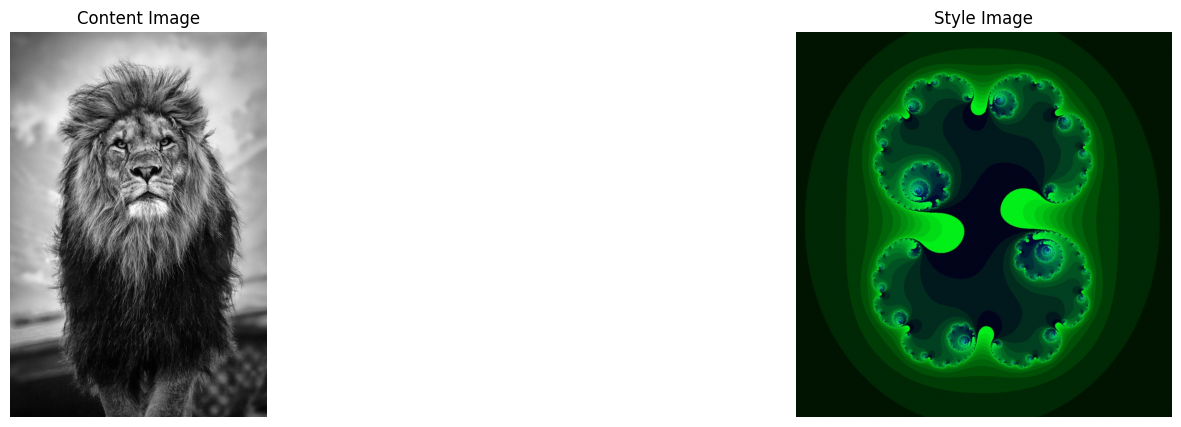

In [4]:
print(f"Resolution content_img: {content_img.shape}, style_img: {style_img.shape}")
print(f"Range of values in content image: {np.min(content_img)} - {np.max(content_img)} , range of values in style image: {np.min(style_img)} - {np.max(style_img)}")

# displaying content, style and generated style transferred images
fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].imshow(content_img)
ax[0].title.set_text('Content Image')
ax[0].axis('off')

ax[1].imshow(style_img)
ax[1].title.set_text('Style Image')
ax[1].axis('off')

plt.show()

In [5]:
# loading pretrained VGG19 model
base_model_vgg = tf.keras.applications.VGG19(include_top=False , weights='imagenet')
base_model_vgg.summary()

2022-11-08 09:10:46.158094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 09:10:46.175977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 09:10:46.176128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 09:10:46.176675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [6]:
# selecting layers (by name included in model summary) for extracting the content and style of an image
# inner layers other than the ones selected are also potential choices for extracting content and style

style_layer_names   = ['block1_conv1',
                       'block2_conv1',
                       'block3_conv1',
                       'block4_conv1',
                       'block5_conv1']
num_style_layers    = len(style_layer_names)

content_layer_name  = ['block5_conv2']
assert (len(content_layer_name) == 1) , 'code assumes only 1 content layer is used'

print("Number of style layers used: {}".format(num_style_layers))

Number of style layers used: 5


In [7]:
# defining function which returns a model for extracting outputs from inner layers of VGG19
def get_model_layer_outputs(base_model, style_layer_names, content_layer_names):
  layer_names = style_layer_names + content_layer_names
  outputs = [base_model.get_layer(name).output for name in layer_names]
  model   = tf.keras.Model([base_model.input], outputs)
  print(model.summary())
  model.trainable = False
  return model

model = get_model_layer_outputs(base_model_vgg, style_layer_names, content_layer_name)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
# defining function for computing the Gram Matrix
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape   = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # total number of i,j pixel locations . computing for normalizing the result
  return result/num_locations


In [9]:
# defining function for extracting image style and content
# img_tensor - input image tensor for which style and content features are calculated
# mode_layer_outputs - model for extracting style and content outputs .
def extract_style_content(img_tensor, model) :
  preprocessed_img = tf.keras.applications.vgg19.preprocess_input(img_tensor*255.) # preprocessing specific to vgg19 model. Multiplying by 255. since preprocess function expects float inputs in range 0-255.
  outputs = model(preprocessed_img)
  content_output = outputs[-1] # selecting last output and
  style_outputs  = outputs[:-1] # a list of style layer outputs
  style_outputs  = [gram_matrix(style_output) for style_output in style_outputs] # extracting style for each style layer using Gram matrix
  return style_outputs, content_output


In [10]:
# defining the loss function
# target_style_outputs refers to style outputs of the style image
# target_content_output refers to content output of the content_image
def custom_loss(style_outputs, content_output, target_style_outputs, target_content_output) :
  # style_weight = 1e-2  # tunable hyperparameter
  # content_weight = 1e4 # tunable hyperparameter
  style_weight = 1e6
  content_weight = 5e1

  style_layer_losses = [ tf.reduce_mean((output - target_output)**2) for output, target_output in zip(style_outputs, target_style_outputs)  ]
  style_loss = tf.add_n(style_layer_losses)/len(style_layer_losses)

  content_loss = tf.reduce_mean( (content_output - target_content_output)**2  )

  total_loss = style_weight*style_loss + content_weight*content_loss
  return total_loss


In [11]:
# initializing various parameters

# computing target content and style outputs
content_img_tensor = tf.expand_dims(tf.constant(content_img),axis=0)
_ , target_content_output = extract_style_content( content_img_tensor , model) # selecting content of content image

style_img_tensor = tf.expand_dims(tf.constant(style_img),axis=0)
target_style_outputs, _ = extract_style_content( style_img_tensor , model) # selecting style of style image


2022-11-08 09:10:47.476047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500
2022-11-08 09:10:49.129205: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-08 09:10:49.129259: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-08 09:10:49.908996: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-08 09:10:51.177537: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of 

In [12]:
# defining the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [13]:
# defining a function to clip the pixel values to the range 0-1 (used during training)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [14]:
# defining function for converting from tensor to image (for using during visualization of the generated image)
def tensor_to_image(tensor):
  tensor = tensor*255
  arr = np.array(tensor, dtype=np.uint8)
  arr = arr[0]
  return PIL.Image.fromarray(arr)

In [15]:
# defining function for single step through the training loop
@tf.function()
def train_step(img, model, optimizer, target_style_outputs, target_content_output):

  with tf.GradientTape() as tape :
    style_outputs, content_output = extract_style_content(img, model)
    loss = custom_loss(style_outputs, content_output, target_style_outputs, target_content_output)

  grad = tape.gradient(loss, img)
  optimizer.apply_gradients([(grad,img)])
  img.assign(clip_0_1(img))


img shape: (1, 1095, 730, 3)


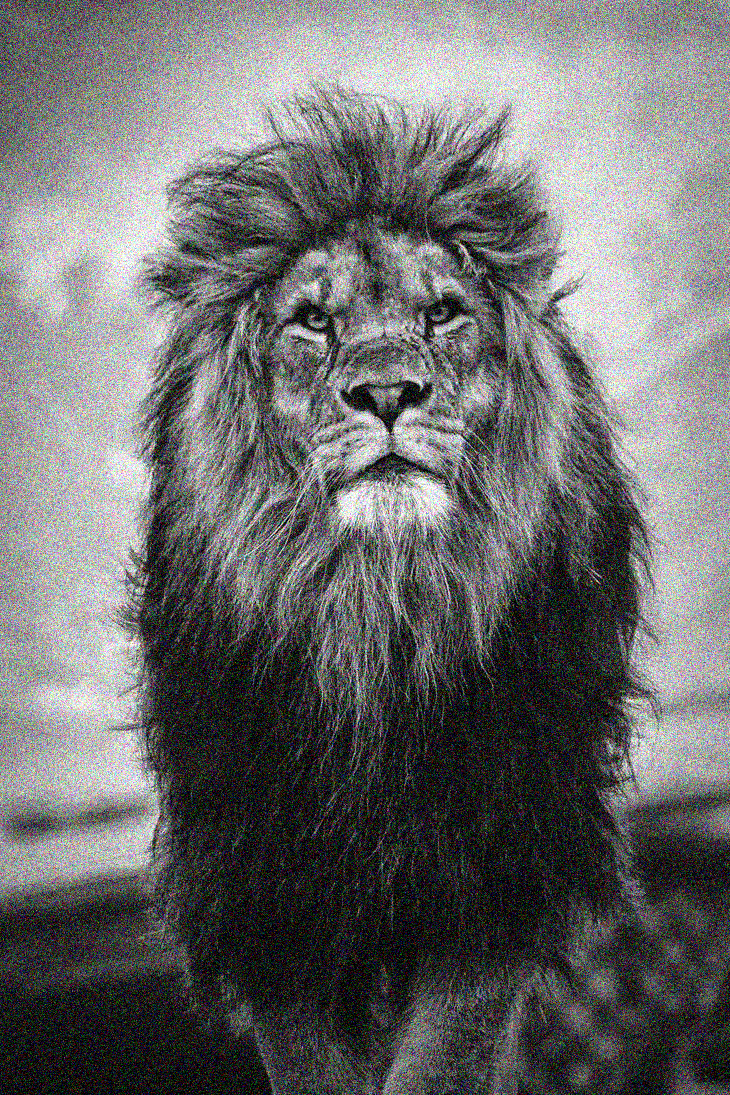

In [16]:
# initializing the input image which will be updated during training and is the same as the generated style-transferred image
img = content_img.copy() + 0.15*np.random.randn(*content_img.shape) # initializing generated image to be same as content image + added random noise
img = np.clip(img, 0. , 1.)
img = np.expand_dims(img, axis=0)
print(f"img shape: {img.shape}")

img = tf.Variable(img) # converting to tensorflow variable

# visualizing initial image
display.display(tensor_to_image(img))


In [17]:
# defining the training loop
num_epochs = 2
steps_per_epoch = 1000
step = 0

start = time.time()
for n in range(num_epochs) :
  for m in range(steps_per_epoch):
    step = step + 1
    train_step(img, model, optimizer, target_style_outputs, target_content_output)
    display.clear_output(wait=True)
    display.display(tensor_to_image(img))
    print(f"Train step: {m}",end='')
    print(f"Train epoch: {n}")
  # display.clear_output(wait=True)
  display.display(tensor_to_image(img))
  print("Train step: {}".format(step))
  print(f"Train epoch: {n}")
end = time.time()

print("Total training time: {:.1f} seconds".format(end-start))

KeyboardInterrupt: 

In [ ]:
 # displaying content, style and generated style transferred images
fig, ax = plt.subplots(1, 3, figsize=(15,10))

ax[0].imshow(content_img)
ax[0].title.set_text('Content Image')
ax[0].axis('off')

ax[1].imshow(style_img)
ax[1].title.set_text('Style Image')
ax[1].axis('off')

generated_img = np.array(tensor_to_image(img))
ax[2].imshow(generated_img)
ax[2].title.set_text('Generated Image')
ax[2].axis('off')

plt.show()
# fig.savefig('convert_basquiat.png')

In [ ]:
from PIL import Image
im = Image.fromarray(generated_img)
im.save("lion_fractol.jpg")